# Yield Curve Inversions
### Aritra Chowdhury (ac79277)

### Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from matplotlib.lines import Line2D

### Data Connection

In [2]:
from fredapi import Fred
fred = Fred(api_key='023d2116c9ffee525fcba5743b4d07d5')

import wrds
db = wrds.Connection()

Enter your WRDS username [aritr]:arichowdhury
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


### Date Parameters

In [3]:
start_date = '1977-12-31'
end_date = '2020-12-31'

### S&P 500 TR Index Data

The data is sourced from [WRDS](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/index-sp-500-indexes/index-file-on-sp-500/).

**Frequency:** Daily

In [4]:
# S&P 500 (TR) (Daily)
query_string = f"""SELECT * FROM crsp.dsp500 where caldt >= '{start_date}' and caldt <= '{end_date}'"""
df_sp500tr = db.raw_sql(query_string)
df_sp500tr['Return'] = (df_sp500tr['vwretd'] + 1).cumprod()
df_sp500tr = df_sp500tr[['caldt', 'Return']].rename(columns = {'caldt': 'Date'}).set_index('Date')

### Yield Inversion Data

The difference between the U.S. Treasury 10-year and 2-year Yields is sourced from [FRED Economic Data](https://fred.stlouisfed.org/series/T10Y2Y).

**Frequency:** Daily

In [5]:
# Treasury Yield 10 Years - 2 Years (Daily)
df_yielddiff = pd.DataFrame(fred.get_series('T10Y2Y')).reset_index()
df_yielddiff['0'] = pd.to_numeric(df_yielddiff[0], errors = 'coerce')
df_yielddiff = df_yielddiff.dropna(how = 'any').rename(columns = {'index': 'Date', 0: 'Yield Inversion'})
df_yielddiff['Date'] = pd.to_datetime(df_yielddiff['Date'], format = '%Y-%m-%d')
df_yielddiff = df_yielddiff[(df_yielddiff['Date'] >= start_date) & (df_yielddiff['Date'] <= end_date)]
df_yielddiff['Yield Inversion'] = df_yielddiff['Yield Inversion'].apply(lambda x: x < 0).astype(int).apply(lambda x: x)
df_yielddiff['Date'] = pd.to_datetime(df_yielddiff['Date'].dt.strftime("%Y-%m-01"))
df_yielddiff = df_yielddiff.groupby('Date').max()

inverted_yield_dates = []

for i in range(1, len(df_yielddiff) - 1):
    if df_yielddiff['Yield Inversion'].iloc[i] == 1:
        if df_yielddiff['Yield Inversion'].iloc[i-1] == 0:
            inverted_yield_dates.append(df_yielddiff.index[i])
        elif df_yielddiff['Yield Inversion'].iloc[i+1] == 0:
            inverted_yield_dates.append(df_yielddiff.index[i])

### NBER Recession Data

NBER based U.S. Recession Indicator data is sourced from [FRED Economic Data](https://fred.stlouisfed.org/series/USRECM). 

**Frequency:** Monthly

In [6]:
# NBER based US Recession Indicators (Monthly)
df_recession = pd.DataFrame(fred.get_series('USRECM')).reset_index()
df_recession['USRECM'] = pd.to_numeric(df_recession[0], errors = 'coerce')
df_recession = df_recession.dropna(how = 'any').rename(columns = {'index': 'Date', 0: 'Recession Flag'})
df_recession['Date'] = pd.to_datetime(df_recession['Date'], format = '%Y-%m-%d')
df_recession = df_recession[(df_recession['Date'] >= start_date) & (df_recession['Date'] <= end_date)]
df_recession.set_index('Date', inplace = True)

recession_dates = []

for i in range(1, len(df_recession) - 1):
    if df_recession['Recession Flag'].iloc[i] == 1:
        if df_recession['Recession Flag'].iloc[i-1] == 0:
            recession_dates.append(df_recession.index[i])
        elif df_recession['Recession Flag'].iloc[i+1] == 0:
            recession_dates.append(df_recession.index[i])

### Yield Curve Inversion Plot

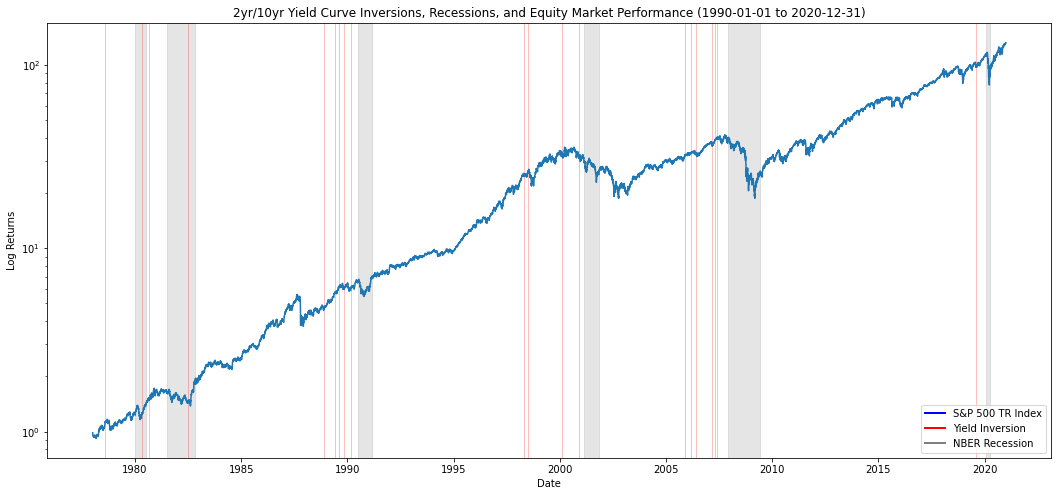

In [7]:
plt.figure(figsize = [18,8])
for xc in inverted_yield_dates:
    plt.axvline(x = xc, color = 'red', alpha = 0.5, linestyle = '-', lw = 0.5)
for i in range(0, len(recession_dates), 2):
    plt.axvspan(recession_dates[i], recession_dates[i+1], alpha=0.2, color='grey')
plt.plot(df_sp500tr['Return'])
plt.yscale('log')
plt.title('2yr/10yr Yield Curve Inversions, Recessions, and Equity Market Performance (1990-01-01 to 2020-12-31)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
colors = ['blue', 'red', 'grey']
lines = [Line2D([0], [0], color = c, linewidth = 2, linestyle = '-') for c in colors]
labels = ['S&P 500 TR Index', 'Yield Inversion', 'NBER Recession']
plt.legend(lines, labels)
plt.show()